In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib qt

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from datetime import datetime
from datetime import timedelta as dt_timedelta

from renewableopt.data import load_by_day
from renewableopt.optimal_design import SinglePeriodModel, MultiPeriodModel, greedy_battery_control, visualize
from renewableopt.peak_id import timedelta, identify_worst_days, assert_int, shape_by_day
from renewableopt.optimal_design.dispatch import DispatchData
from renewableopt.optimal_design.multi_period import OptimizationError

In [4]:
sources = ["solar", "wind", "geothermal"]
time, load, generation_pu = load_by_day(0, 366, sources=sources)
generation_pu[:, 1] *= np.pi
generation_pu[:, 1] = np.clip(generation_pu[:, 1], None, 1.0)
time = time / 60
dt = timedelta(time)
_, timesteps_per_day = shape_by_day(time)
peak_data = identify_worst_days(time, load, generation_pu,
                              sources=sources, method="manual_cluster")
#                               sources=sources, method="kmeans_cluster")

worst_load, worst_generation_pu = peak_data.load, peak_data.gen_pu

In [5]:
time.shape

(105408,)

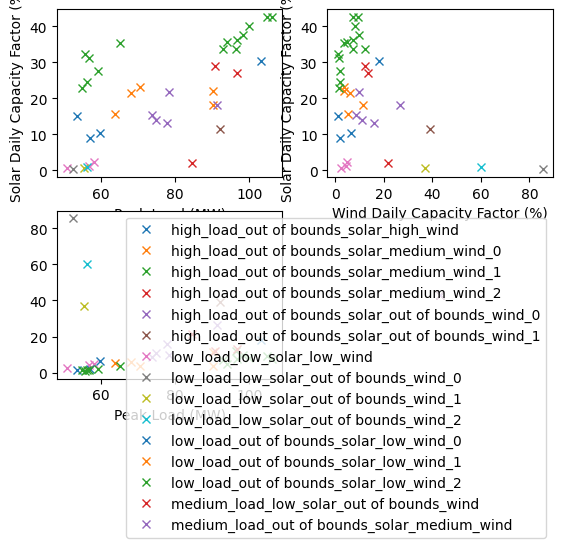

In [10]:
visualize.plot_wind_solar_cluster(peak_data)

In [6]:
print(list(worst_load.keys()))

['low_load_low_solar', 'medium_load_low_solar', 'medium_load_medium_solar', 'high_load_cloudy', 'high_load_sunny']


In [7]:
scenario = list(worst_load.keys())[-1]
time_hr = time / 60
plt.plot(worst_load[scenario])
plt.figure()
plt.plot(worst_generation_pu[scenario])
plt.legend(sources)

In [34]:
scenario = list(worst_load.keys())[0]
time_one_day = time[:worst_load[scenario].shape[0]]
geo_om = 3500
solar_wind_om = 0
model = MultiPeriodModel(
    initial_battery_charge=0.5,
    depth_of_discharge=0.1,
    cost_battery_energy=300,
    cost_battery_power=350,
    cost_generation=[1250 + solar_wind_om, 1250 + solar_wind_om, 3500 + geo_om])
#     cost_generation=[1250])
try:
    res = model.minimize_cost(time_one_day, worst_load, worst_generation_pu)
except OptimizationError as err:
    scipy_res = err.result
    raise err

In [35]:
def total_cost_energy(time, load, result):
    total_energy_over_year = np.sum(load) * timedelta(time)
    return 100 * res.result.fun / total_energy_over_year  # 100cent/$ * $1000 / MWh == cents/KWh

In [36]:
print(f"Battery Capacity {res.E_max:.1f} MWh")
print(f"Battery Power {res.P_battery:.1f} MW")
print(f"Hours of storage: {res.E_max / res.P_battery:.2f} hr")
for i, source in enumerate(sources):
    print(f"{source.capitalize()} Generation: {res.P_generation[i]:.1f} MW")
#     print(f"Geothermal Generation: {res.P_generation[i]:.1f} MW")
c = total_cost_energy(time, load, res)
print(f"Total cost of energy: {c:.1f} cent/kWh")


Battery Capacity 315.7 MWh
Battery Power 37.9 MW
Hours of storage: 8.33 hr
Solar Generation: 55.4 MW
Wind Generation: 22.5 MW
Geothermal Generation: 51.5 MW
Total cost of energy: 138.5 cent/kWh


In [19]:
np.mean(generation_pu, axis=0)

array([0.28183511, 0.24349791, 1.        ])

In [124]:
# Potentially interesting plots:
# Aggregated SoC at end of day (mean/std of each month) (of course, this depends on eta)
#     Include also minimum SoC
# SoC over day for the day in each month that reaches minimum battery capacity 
# Amount of renewable generation curtailment (to what degree is this a function of generation source?)

In [35]:
def capacity_factor_plot(generation, columns=None):
    gen_pu = np.array(generation)
    gen_pu_per_day = gen_pu.reshape(366, -1, 3)
    daily_cap = np.sum(gen_pu_per_day, axis=1) * dt / 24
    daily_cap *= 100  # Convert to percent.
    
    plt.figure()
    yearly_cap = np.mean(daily_cap, axis=0)
    if columns is None:
        columns = generation.columns
    for source in columns:
        i = list(generation.columns).index(source)
        plt.plot(np.sort(daily_cap[:, i])[::-1], label=source.capitalize())
    for j, source in enumerate(columns):
        i = list(generation.columns).index(source)
        label = f"Yearly Capacity Factor: {source.capitalize()} ({yearly_cap[i]:.1f}%)"
        plt.axhline(y=yearly_cap[i], linestyle='--', color=f"C{j}", label=label)
    
    plt.title("Solar and Wind Daily Capacity Factors")
    plt.xlabel("Number of days with at least x capacity factor")
    plt.ylabel("Capacity factor (%)")
    plt.legend()

In [28]:
import pandas as pd

In [30]:
generation_df = pd.DataFrame({
    source: generation_pu[:, i]
    for i, source in enumerate(sources)
})

In [36]:
capacity_factor_plot(generation_df, columns=sources[:2])

In [125]:
# Is there a good way to store all this data in a single data structure, so that passing it
# to visualization function isn't so onerous?

In [20]:
def day_to_date(days):
    jan1 = np.datetime64("2012-01-01 00:00")
    return jan1 + np.array(days * 24).astype('timedelta64[h]')

In [21]:
{
    name: day_to_date(v)
    for name, v in peak_data.problem_groups.items()
}

{'low_load_low_solar': array(['2012-03-17T00:00', '2012-11-30T00:00', '2012-12-13T00:00',
        '2012-12-18T00:00'], dtype='datetime64[m]'),
 'medium_load_low_solar': array(['2012-07-12T00:00'], dtype='datetime64[m]'),
 'medium_load_medium_solar': array(['2012-09-09T00:00'], dtype='datetime64[m]'),
 'high_load_cloudy': array(['2012-08-12T00:00', '2012-08-13T00:00'], dtype='datetime64[m]'),
 'high_load_sunny': array(['2012-07-27T00:00', '2012-07-28T00:00'], dtype='datetime64[m]')}

In [22]:
def day_indices(time, day):
    dt = visualize.as_datetime(time)
    return np.logical_and(
        dt >= day,
        dt < day + np.timedelta64(24, 'h')
    )

In [23]:
day = np.datetime64("2012-07-27")
day_indices(time, day).shape

(105408,)

In [24]:
timesteps_per_day

288

Feasible? True


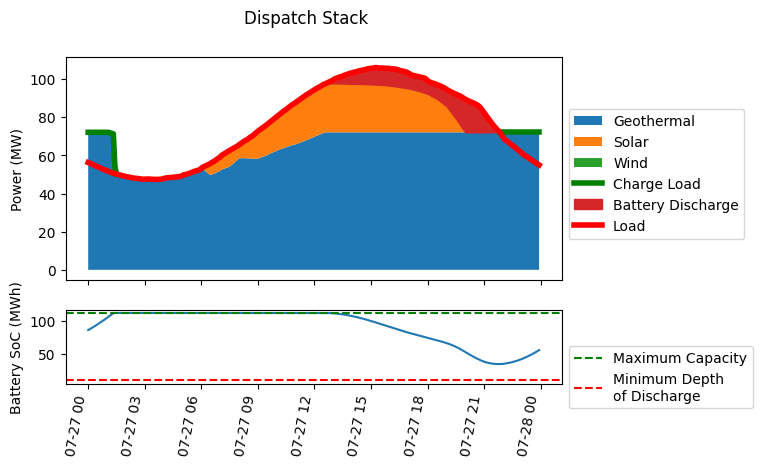

In [26]:
dispatch = DispatchData.from_greedy(time, load, generation_pu, sources, res, peak_data)
print(f"Feasible? {dispatch.feasible}")
indices = (
    day_indices(time, day)
    if dispatch.feasible else
    slice(len(dispatch) - timesteps_per_day, None))
visualize.plot_stack(
    dispatch[indices],
    curtailment="even")

In [65]:
dispatch.by_day(10)

In [62]:
josh_cost = 60 * 3500 + 1250 * 50 + 1250 * 50 + 50 * 350 + 400 * 300

76.5109198649304

In [64]:
100 * josh_cost / total_energy_over_year  # 100cent/$ * $1000 / MWh == cents/KWh

115.62217018522118

In [133]:
visualize.storage_capacity_statistics(dispatch)

In [55]:
visualize.daily_curtailment(dispatch)

In [134]:
visualize.min_capacity_per_month(dispatch, [12])

converted
<class 'numpy.datetime64'>


In [30]:
visualize.lp_versus_greedy_comparison(res, time_one_day, worst_load, worst_generation_pu,
                                      scenarios=['high_load_sunny'])

In [25]:
res.scenarios

['low_load_low_solar',
 'medium_load_low_solar',
 'medium_load_medium_solar',
 'high_load_cloudy',
 'high_load_sunny']

In [36]:
from renewableopt.optimal_design import SinglePeriodModel

In [37]:
help(SinglePeriodModel)

Help on class SinglePeriodModel in module renewableopt.optimal_design.single_period:

class SinglePeriodModel(builtins.object)
 |  SinglePeriodModel(initial_battery_charge, depth_of_discharge, cost_battery_energy, cost_solar)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, initial_battery_charge, depth_of_discharge, cost_battery_energy, cost_solar)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  minimize_cost(self, time, load, solar_pu)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



In [38]:
model = SinglePeriodModel(
    initial_battery_charge=0.5,
    depth_of_discharge=0.1,
    cost_battery_energy=100,
    cost_solar=50
)

In [23]:
model.minimize_cost(time, load, generation_pu[:, 0])

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [19]:
res.E_max / res.P_battery

1.0529862514653137

In [21]:
set([1, 2, 3]) - set([2])

{1, 3}